<h1>Machine Learning to Identify Toxic Comments: EDA & Baselines</h1>

### Breif Overview of Problem Statement:

With too much freedom in social media, profanity in comments (i.e. comments that are disrespectful, rude or otherwise likely to make someone leave a discussion) can be a serious issue if not addressed. Moreover, with surge in number users accessing social media these days, this task cannot be done manually with help of moderators. So to automate the identification of toxic comments on social media platforms, The Conversation AI team had come up with an interesting kaggle competition to build a roboust machine learning model that can do this task.

For this competition, we are provided a annotated dataset of comments from Wikipedia’s talk page edits. Using this as training data, we are challenged to build a multi-headed machine learning model that is capable of detecting different types of of toxicity like obscenity, threats, insults, and identity-based hate better than existing machine learning models (yes, conversational AI team already has a model to do this).

More details of the competition can be found here: 
> source: [kaggle](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)


### Data & Evaluation metrics:

`train.csv` contains a large number of Wikipedia comments (around 100K+) which have been labeled by human raters for toxic behavior. The types of toxicity are:

`toxic
 severe_toxic
 obscene
 threat
 insult
 identity_hate`
 
- Apart from the above mentioned classes there will be also completely clean comments.
- The trained model will be tested on `test.csv` data using mean column-wise ROC AUC as evaluation metric.
- **Mean column-wise ROC AUC = Average of the individual ROC AUC scores of each predicted class. **

Submission File Format:

For each id in the test set, you must predict a probability for each of the six possible types of comment toxicity (toxic, severetoxic, obscene, threat, insult, identityhate). The columns must be in the same order as shown below. The file should contain a header and have the following format:

`id,toxic,severe_toxic,obscene,threat,insult,identity_hate
 00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
 0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
 etc.`

#### Objective of this Notebook: 
- Explore the data, perform analysis & build baselines.

### Reading the Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
data_paths = {}
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        data_paths[filename] = os.path.join(dirname, filename)
        # print(os.path.join(dirname, filename))
        
train_df = pd.read_csv(data_paths['train.csv'])
test_df = pd.read_csv(data_paths['test.csv'])
sub_df = pd.read_csv(data_paths['sample_submission.csv'])
print('Train data shape:', train_df.shape)
print('Columns in Train:', train_df.columns)

Train data shape: (159571, 8)
Columns in Train: Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')


The provided `train.csv` is having 159571 rows and 8 columns. Let us now sample to take 5 rows from the data to get visual understanding of what is present.

In [2]:
train_df.sample(5, random_state = 1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
24915,41e65f43c180838e,"YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...",1,1,1,0,1,0
75819,cade9e425d75948e,Agent X2: Basically thanks - with a 'little' m...,0,0,0,0,0,0
53891,8ff87747403ed2e6,Why are my posts being deleted? \n\nI have tri...,0,0,0,0,0,0
154159,a95604c7a938abb3,"""\n\n Controlled Demolitions and Common Sense ...",0,0,0,0,0,0
13040,2288910537399728,I do not understand your reply. //Blaxthos ( ...,0,0,0,0,0,0


- This is going to be text classification problem...we are given a comment and we need to classify whether it is toxic.
- The column `comment_text` contains the comments text and it will be our main feature.
- All the remaining columns except `id` will be our target variable to predict.
- Target varaibles are binary encoded (one hot encoded) & all zeros represents a clean comment.
- A single comments can belong to multiple toxicity classes

Now lets look into few complete random comments from the data

In [3]:
for i in [34, 55345, 124786]:
    display(train_df.loc[i, 'comment_text'])

'"\nWell, not ""before the process"" but ""before how we do things with subpages"" His RfA is listed on NoSeptember\'s page and you can find it if you look. September 2004 I think. I have my differences with El_C to be sure, but was surprised to see a block, so I left a note. ++: t/c "'

'They are deletionists.'

"Hello \n\nHello, I'm Irene.\n\nI created See Me novel from Nicholas Sparks. I created it because I saw Nicholas Spark's official website about a new novel released coming soon. I ask you, is this page wrong or anything?\n\nThanks."

Clearly, comments are largely varying in lengths. Let us see how their distrubution looks like

Central Tendencies on lengths of comment_text
 count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_text, dtype: float64


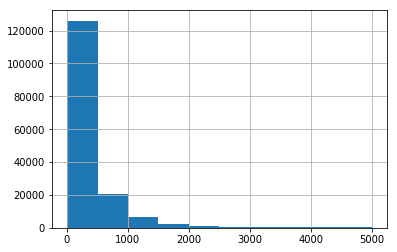

In [4]:
comment_lens = train_df['comment_text'].str.len()
print('Central Tendencies on lengths of comment_text\n', comment_lens.describe())
ax = comment_lens.hist()

From the above outputs we can say these points:

- Comments have no null values.
- Mininum length of a comment is only 6 chars while maximum length can be 5000 characters.
- Mean (394 chars) and median (205 chars) are not close indicating the skewness - as a result histogram is left sided

Now we will look how many of given comments are clean & how many are toxic (in other words, distrubution of classes to be predicted)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

drop_col = ['id', 'is_clean']  # columns not neccessary - can be dropped
text_col = ['comment_text']  # text feature
label_col = [col for col in train_df.columns if col not in text_col + drop_col] # target variables

labels_per_comment = train_df[label_col].sum(axis = 1) # clac no.of labels for each comment

# add a new column to indicate if a comment is toxic (bad) or not (clean).
train_df['is_clean'] = 0
train_df.loc[labels_per_comment == 0, 'is_clean'] = 1
# train_df['is_clean'].value_counts()

print("Total Clean comments (All 0's in a target row) in train:",len(train_df[train_df['is_clean'] == 1]))
print("Total unclean/bad comments (atleast one 1 in a target row)in train:",len(train_df[train_df['is_clean'] != 1]))
print("Total label tags (total counts of 1's in target columns):",train_df[label_col].sum().sum())

Total Clean comments (All 0's in a target row) in train: 143346
Total unclean/bad comments (atleast one 1 in a target row)in train: 16225
Total label tags (total counts of 1's in target columns): 35098


Importantly we need to notice that total bad comments & total label tags are not equal, so said intially there are multiple labels for many comments. On Average, there are 2 labels for each comment - but let us see - Now let us see how multiple labels are divided:

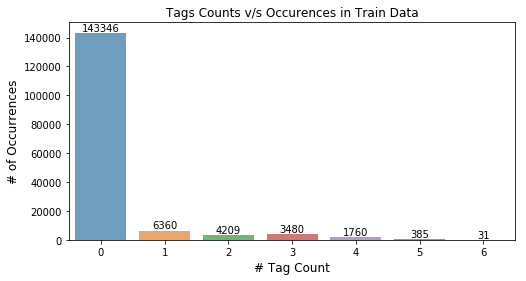

In [6]:
tags_count = labels_per_comment.value_counts()

# plotting the label counts
plt.figure(figsize=(8,4))
ax = sns.barplot(tags_count.index, tags_count.values, alpha=0.7)
plt.title("Tags Counts v/s Occurences in Train Data")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# Tag Count', fontsize=12)

#adding the text labels
rects = ax.patches
labels = tags_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, 
            label, ha='center', va='bottom')

plt.show()

- maximum no.of tags for a bad comment is 6 (i.e it will belong to all six classes).
- This we can be viewed as highericial tagging. (Ex: A comment which is `severe_toxic` will be also a `toxic`).

Lets visualize how the main six classes are distributed (counts of classes) among the 35098 occurences

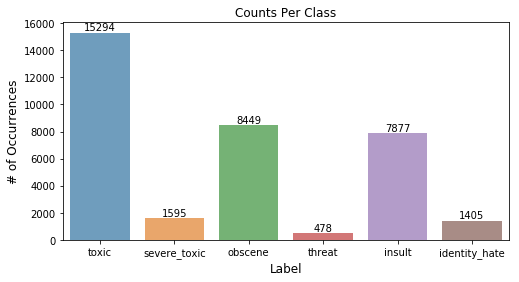

In [7]:
label_counts = train_df[label_col].sum()

# plotting the label counts
plt.figure(figsize=(8,4))
ax = sns.barplot(label_counts.index, label_counts.values, alpha=0.7)
plt.title("Counts Per Class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Label', fontsize=12)

#adding the text labels
rects = ax.patches
labels = label_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, 
            label, ha='center', va='bottom')

plt.show()

The above figure tells us that Toxicity type is not evenly spreadout - `toxic` comments are more common while `threat` is least occuring class. This is interesting & a bit scary too. In total, there is a high imbalance b/w the clean & unclean comments. Again with in unclean comments, there is imbalance b/w the types of toxicity!

Till now we only analyzed the target varaibles, now we will look at one comment each from the all 6 types of toxic classes.

In [8]:
import random
for label in label_col:
    label_df = train_df[train_df[label]==1].reset_index(drop = 1)
    print('\n' + label + ' - comment sample :')
    print(label_df.loc[random.randint(0, len(label_df)-1), 'comment_text'])
    print('\n' + '-'*50)


toxic - comment sample :
Rjanag, your foul language showed your true white trash mentality. You being white prove more of your bias and hideous intent. Keep your effort in trying to hide the truth. If you can certainly call up your gang to block people from Wikipedia, it only serves as proof of your fear of the truth.

--------------------------------------------------

severe_toxic - comment sample :
what i mean to say is that im a big fucknig idiot and i dont know what im talking about

--------------------------------------------------

obscene - comment sample :
Warning
Get off your high horse with warnings and referring to your talk page as if it were another user. You're no admin, but like the other assclowns that have gotten on my case, you seem to think you've got cred by throwing warnings at me. No one is gonna check the talk page of a low importance-rated article and you know it, you dumbfuck.

--------------------------------------------------

threat - comment sample :
I'l

- Aah...that's a lot of profanity...!
- Comments are having puntuctions & things user want to highlight in captials (or) quotes.
- As usually, Contractions are always there. In some cases (very less), there is also text from other languages in b/w english.
- comments include lots of chatting/social shortcuts which we generally use on social media.
- few comments seems to contain numbers, time and also IP address (might be of user's).
- In few cases there are also Device Id's and Urls posted by users.
- Some comments are spam - repeating same things 10's of times.
- In few rare cases, I found the word `unblock` before the comment - this might indicate that comment is blocked as it is toxic.

Now, let us start exploring into comment texts with some questions which relates to our objective. Our objective here is to classify the bad comments into different to toxicity types.

- Are Longer comments more toxic ?
- did Presence of special characters vary with Toxicity ?
- Are spammer more toxic ?


These questions will answer how Toxicity of comments vary with different features of comment_text like length, presence of punctuations, capital letters, words, or sentences.

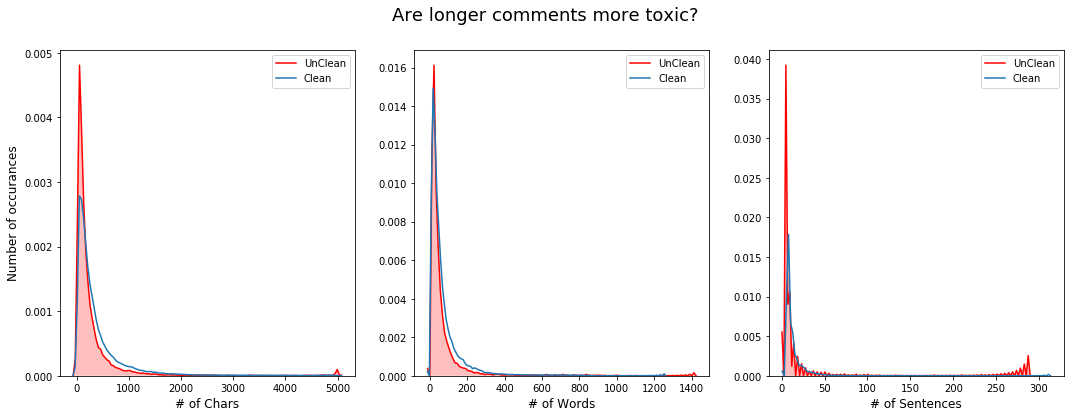

In [9]:
import re

#Total chars:
train_df['total_len'] = train_df['comment_text'].apply(len)
test_df['total_len'] = test_df['comment_text'].apply(len)

#Sentence count in comment: '\n' is split & count number of sentences in each comment
train_df['sent_count'] = train_df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
test_df['sent_count'] = test_df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)

#Word count in each comment:
train_df['word_count'] = train_df["comment_text"].apply(lambda x: len(str(x).split()))
test_df['word_count'] = test_df["comment_text"].apply(lambda x: len(str(x).split()))


plt.figure(figsize=(18,6))
plt.suptitle("Are longer comments more toxic?",fontsize=18)
plt.tight_layout()

# total lengths (characters)
plt.subplot(131)
ax=sns.kdeplot(train_df[train_df.is_clean == 0].total_len, label="UnClean",shade=True,color='r')
ax=sns.kdeplot(train_df[train_df.is_clean == 1].total_len, label="Clean")
plt.legend()
plt.ylabel('Number of occurances', fontsize=12)
plt.xlabel('# of Chars', fontsize=12)
# plt.title("# Chars v/s Toxicity", fontsize=12)

# words
plt.subplot(132)
ax=sns.kdeplot(train_df[train_df.is_clean == 0].word_count, label="UnClean",shade=True,color='r')
ax=sns.kdeplot(train_df[train_df.is_clean == 1].word_count, label="Clean")
plt.legend()
plt.xlabel('# of Words', fontsize=12)
# plt.title("# Words v/s comment Toxicity", fontsize=12)

## sentences
plt.subplot(133)
ax=sns.kdeplot(train_df[train_df.is_clean == 0].sent_count, label="UnClean",shade=True,color='r')
ax=sns.kdeplot(train_df[train_df.is_clean == 1].sent_count, label="Clean")
plt.legend()
plt.xlabel('# of Sentences', fontsize=12)
# plt.title("# Sentences v/s comment Toxicity", fontsize=12)

plt.show()

- most comments are having less than 25 sentences & less than 250 words
- unclean comments are having more no.of words in less no.of sentences.
- The distrubution plots of clean & unclean of all three plots are very much overlapping with each others, indicating these features are going to be less significant in differentiating them.

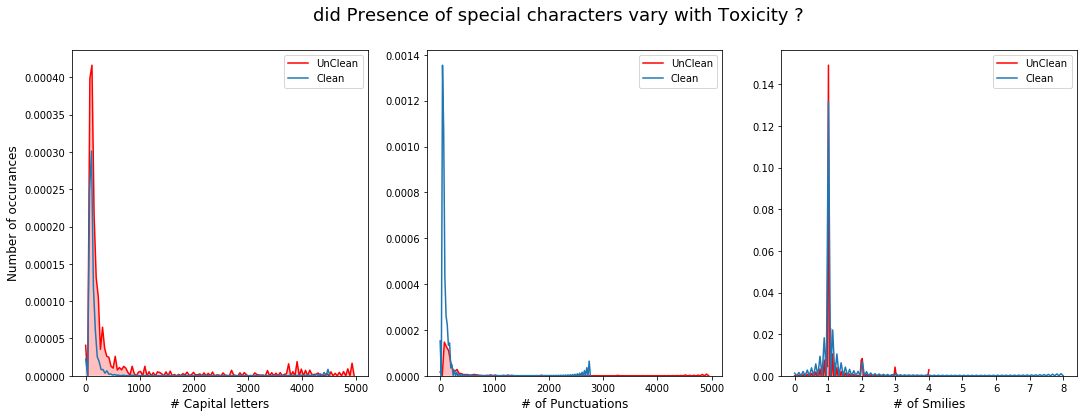

In [10]:
import string

#Captial letters:
train_df['capitals'] = train_df['comment_text'].apply(lambda x: sum(1 for c in x if c.isupper()))
test_df['capitals'] = test_df['comment_text'].apply(lambda x: sum(1 for c in x if c.isupper()))

# #Captials ratio:
# train_df['capitals_percent'] = train_df['capitals']/train_df['total_len'] * 100
# test_df['capitals_percent'] = test_df['capitals']/train_df['total_len'] * 100

# punct count:
train_df['punct_count'] = train_df['comment_text'].apply(lambda x: sum(1 for c in x if c in string.punctuation))
test_df['punct_count'] = test_df['comment_text'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

# smilies:
smilies = (':-)', ':)', ';-)', ';)')
train_df['smilies_count'] = train_df['comment_text'].apply(lambda comment: sum(comment.count(s) for s in smilies))
test_df['smilies_count'] = test_df['comment_text'].apply(lambda comment: sum(comment.count(s) for s in smilies))

#----------plotting------------

plt.figure(figsize=(18,6))
plt.suptitle("did Presence of special characters vary with Toxicity ?\n",fontsize=18)
plt.tight_layout()

# words
plt.subplot(131)
ax=sns.kdeplot(train_df[train_df.is_clean == 0].capitals, label="UnClean",shade=True,color='r')
ax=sns.kdeplot(train_df[train_df.is_clean == 1].capitals, label="Clean")
plt.legend()
plt.ylabel('Number of occurances', fontsize=12)
plt.xlabel('# Capital letters', fontsize=12)
# plt.title("# Captials v/s Toxicity", fontsize=12)

# words
plt.subplot(132)
ax=sns.kdeplot(train_df[train_df.is_clean == 0].punct_count, label="UnClean",shade=True,color='r')
ax=sns.kdeplot(train_df[train_df.is_clean == 1].punct_count, label="Clean")
plt.legend()
plt.xlabel('# of Punctuations', fontsize=12)
# plt.title("#Punctuations v/s comment Toxicity", fontsize=12)

## sentences
plt.subplot(133)
ax=sns.kdeplot(train_df[train_df.is_clean == 0].smilies_count, label="UnClean",shade=True,color='r')
ax=sns.kdeplot(train_df[train_df.is_clean == 1].smilies_count, label="Clean")
plt.legend()
plt.xlabel('# of Smilies', fontsize=12)
# plt.title("#Smilies v/s comment Toxicity", fontsize=12)

plt.show()

- presence of captial letters is more in case of unclean comments, but the distrbutions are overlapping making it a difficult feature for models to extract information.
- most of the clean comments are having punctuations less than 100 while for unclean comments it spread to max of 5000 punctuations.
- no.of smilies in unclean v/s clean comments is very much similar and unclean comments are having more comments with no.of smilies = 1.

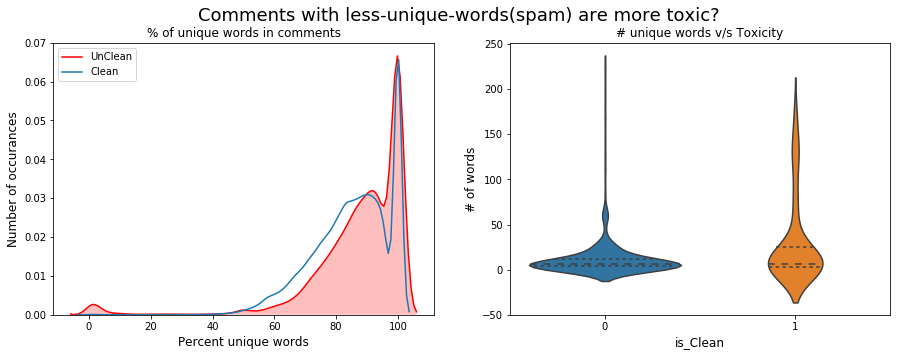

In [11]:
#Unique word count:
train_df['unique_word_count'] = train_df["comment_text"].apply(lambda x: len(set(str(x).split())))
test_df['unique_word_count'] = test_df["comment_text"].apply(lambda x: len(set(str(x).split())))

#Unique ratio:
train_df['unique_word_percent'] = train_df['unique_word_count']/train_df['word_count'] * 100
test_df['unique_word_percent'] = test_df['unique_word_count']/train_df['word_count'] * 100

#----------plotting------------

# comments with unique word count percentage < 25%...they can be spam/referal links/marketing links

plt.figure(figsize=(15,5))
plt.suptitle("Comments with less-unique-words(spam) are more toxic?",fontsize = 18)

plt.subplot(121)
plt.title("% of unique words in comments")
ax=sns.kdeplot(train_df[train_df.is_clean == 0].unique_word_percent, label="UnClean",shade=True,color='r')
ax=sns.kdeplot(train_df[train_df.is_clean == 1].unique_word_percent, label="Clean")
plt.legend()
plt.ylabel('Number of occurances', fontsize=12)
plt.xlabel('Percent unique words', fontsize=12)

plt.subplot(122)
sns.violinplot(y = 'unique_word_count',x='is_clean', data = train_df[train_df['unique_word_percent'] < 25], 
               split=True,inner="quart")
plt.xlabel('is_Clean', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("# unique words v/s Toxicity")
plt.show()

# train_df[train_df['word_unique_percent'] < 25]

- There is a wide spread area for unclean points in the unique word percentage range of 1-10%, Interesting there are clean comments as well with lesser number of unique words. 
- This feature seems carry some significance especially incase of sentences with less unique words.
- lets once see how text in clean-spam & unclean-spam comments look like

In [12]:
## lets have a look how clean & unclean spam comment looks like

print("Clean Spam example:")
print(train_df[train_df['unique_word_percent'] < 10][train_df['is_clean'] == 1].comment_text.iloc[3])
print('-'*50)
print("Toxic Spam example:")
print(train_df[train_df['unique_word_percent'] < 10][train_df['is_clean'] == 0].comment_text.iloc[25])

Clean Spam example:
MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD
--------------------------------------------------
Toxic Spam example:
I OWN THIS PAGE YOU FOOLS!! YOU SHOULD FEAR ME!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I WANT MY CHEESE, GEORGE BUSH SHOULD GO TO HELL!!!!!!!!! I AM THE GOD OF CHOCOBOS, I W

- we definitely need to penalize the over repeating words (or) there will be chance for models to learn as words like 'George Bush' as indicator as toxicity. so comments with lesser unique words should be preprocessed carefully.

- Tfidf is well known for this penalizing effect.
-  TF-IDF Vectorizer
      - TF - Term Frequency -- Count of the words(Terms) in the text corpus (same of Count Vect)
      - IDF - Inverse Document Frequency -- Penalizes words that are too frequent. We can think of this as regularization

In [13]:
train_df.to_csv('train_feateng.csv', index = None)
test_df.to_csv('test_feateng.csv', index = None)

In [14]:
# from nltk.corpus import stopwords
# from nltk import pos_tag
# from nltk.stem.wordnet import WordNetLemmatizer 
# from nltk.tokenize import word_tokenize # Tweet tokenizer does not split at apostophes which is what we want
# from nltk.tokenize import TweetTokenizer


# lemma = WordNetLemmatizer()
# tokenizer=TweetTokenizer()
# eng_stopwords = list(stopwords.words('english'))

# def simple_preprocess(comment):
#     """
#     This function receives comments and returns clean word-list
#     """
#     #Convert to lower case 
#     comment=comment.lower()
#     #remove \n
#     comment=re.sub("\\n","",comment)

#     #Split the sentences into words and lemmatize
#     words=tokenizer.tokenize(comment)
#     words=[lemma.lemmatize(word, "v") for word in words]
#     words = [w for w in words if not w in eng_stopwords]
    
#     clean_sent=" ".join(words)
    
#     return(clean_sent)

# train_df['comment_text'] = train_df['comment_text'].apply(lambda x: simple_preprocess(x))
# test_df['comment_text'] = test_df['comment_text'].apply(lambda x: simple_preprocess(x))

In [15]:
def get_topn_tfidf_feat_byClass(X_tfidf, y_train, feature_names, labels, topn):
    
    feat_imp_dfs = {}
    
    for label in labels:
        # get indices of rows where label is true
        label_ids = y_train.index[y_train[label] == 1]
        # get subset of rows
        label_rows = X_tfidf[label_ids].toarray()
        # calc mean feature importance
        feat_imp = label_rows.mean(axis = 0)
        # sort by column dimension and get topn feature indices
        topn_ids = np.argsort(feat_imp)[::-1][:topn]
        # combine tfidf value with feature name
        topn_features = [(feature_names[i], feat_imp[i]) for i in topn_ids]
        # df
        topn_df = pd.DataFrame(topn_features, columns = ['word_feature', 'tfidf_value'])
        # save 
        feat_imp_dfs[label] = topn_df
    return feat_imp_dfs

### Transforming Text Data into TD-IDF vectors & Analysing TF-IDF values 

#### 1. Visualising Bigram features per Class

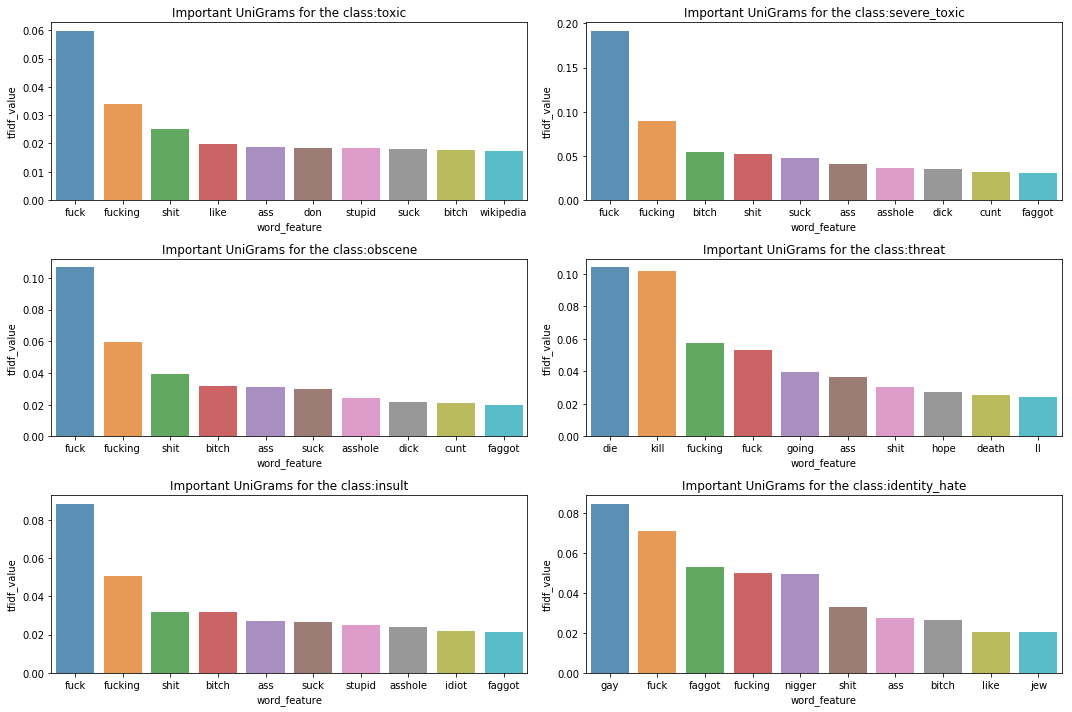

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize # Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer


tfidf = TfidfVectorizer(ngram_range = (1,1), min_df = 100, 
                        strip_accents='unicode', analyzer='word',
                        use_idf=1,smooth_idf=1,sublinear_tf=1,
                        stop_words = 'english')
X_unigrams = tfidf.fit_transform(train_df['comment_text'])
X_unigrams.shape, len(tfidf.get_feature_names())


feature_names = np.array(tfidf.get_feature_names())
imp_dfs = get_topn_tfidf_feat_byClass(X_unigrams, train_df, feature_names, label_col, topn = 10)

plt.figure(figsize=(15,10))

for i, label in enumerate(label_col):
    plt.subplot(3, 2, i + 1)
    sns.barplot(imp_dfs[label].word_feature[:10], imp_dfs[label].tfidf_value[:10], alpha = 0.8)
    plt.title("Important UniGrams for the class:{}".format(label))
    plt.tight_layout()

- few words like `fuck` seems to be in every class, but again as this is multi-label classification (multiple tags for each comment) there will be that overlapping.
- especially `threat` class is standing apart with words like `kill`, `die`, `death`.
- Interestingly, due to high tf-idf value, word `wikipedia` has stands in top10 features for the `toxic` class. which model should not learn.

#### 2. Visualising Bigram features per Class

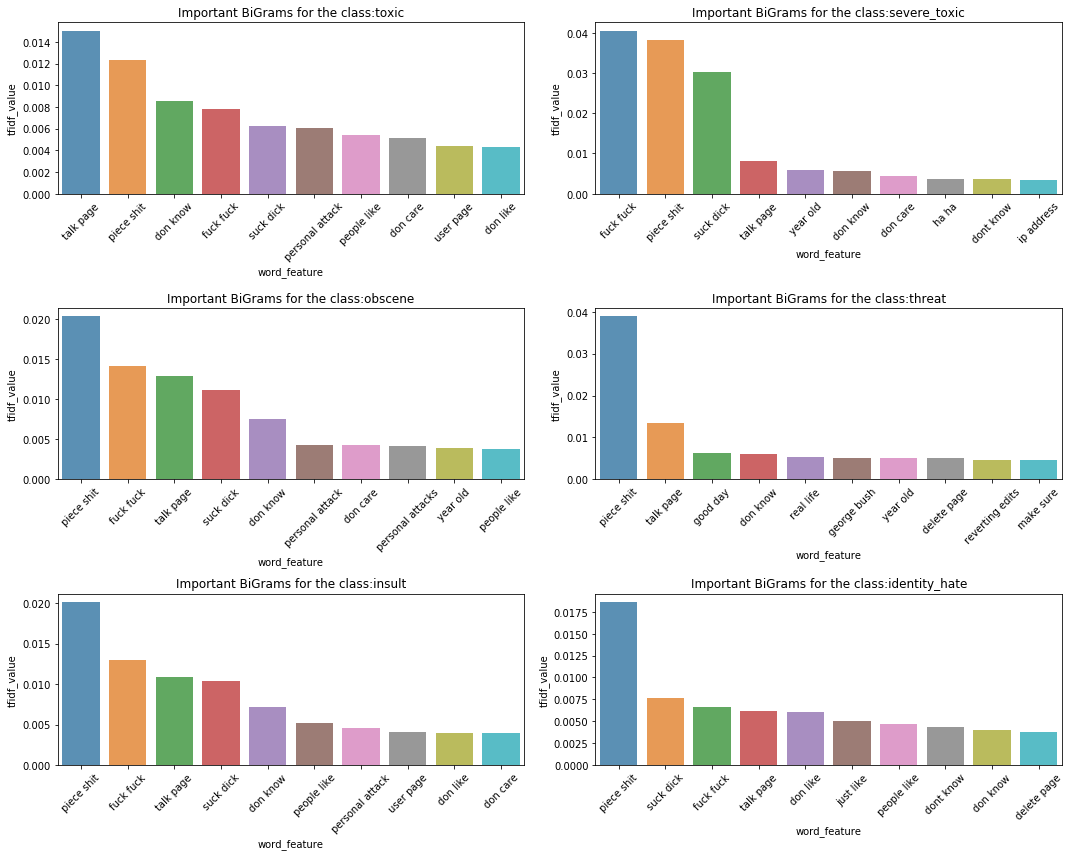

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range = (2,2), min_df = 100, 
                        strip_accents='unicode', analyzer='word',
                        use_idf=1,smooth_idf=1,sublinear_tf=1,
                        stop_words = 'english')
X_bigrams = tfidf.fit_transform(train_df['comment_text'])
X_bigrams.shape, len(tfidf.get_feature_names())

feature_names = np.array(tfidf.get_feature_names())
imp_dfs = get_topn_tfidf_feat_byClass(X_bigrams, train_df, feature_names, label_col, topn = 10)

plt.figure(figsize=(15,12))

for i, label in enumerate(label_col):
    plt.subplot(3, 2, i + 1)
    by_class = sns.barplot(imp_dfs[label].word_feature[:10], imp_dfs[label].tfidf_value[:10], alpha = 0.8)
    plt.title("Important BiGrams for the class:{}".format(label))
    for item in by_class.get_xticklabels():
        item.set_rotation(45)
    plt.tight_layout()

- the top 10 tfidf features in case are not much differentiating, every class are having almost same phrases.
- remember, the `comment_text` is completely unprocessed for now.
- There is high chance for Names of persons like famous names `george bush`, `mitt romney` (if mentioned repeatedly in the spam) to appear in the bigram features for any class. To avoid this we can preprocess spam comments (comments with < 25% unique words) differently like removing usernames/person names from the comments using regular expressions or POS tags.

### Splitting the data into Training & Validation sets:

Before testing the model on the actual test data, we neeed to cross-validate internally that model is trained in a right way. Validation set will also help to tune model properly. I am using sklearn's `train_test_split` utility function to do this random splitting. I am using `random_state = 2019`as seed for purpose of reproducability & `test_size` = 0.2 meaning 20% of data points in the train set will be used as validation data and remaining 80% of data will be used to train the model.



In [18]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_df['comment_text'], 
                                                  train_df[label_col], test_size=0.2, random_state=2019)
X_test = test_df['comment_text']
print('Data points in train data after splitting:', len(X_train))
print('Data points in valiadtion data:', len(X_val))
print('Data points in test data:', len(X_test))

Data points in train data after splitting: 127656
Data points in valiadtion data: 31915
Data points in test data: 153164


### Naive Baselines:

Before getting to actual modelling & algorithms. let me build some naive baseline on validation set to get minimal optimal score. These scores will be useful for analysing & selection of the models we will be building.

#### naive baseline 1: Random guessing probabilities b/w 0 & 1.

This time instead having common probility...we take random value for probability for every column in row. What good is a machine learing if its results are not even better than a random prediction ?

In [19]:
from sklearn.metrics import log_loss, roc_auc_score
y_val_naive1 = np.random.rand(y_val.shape[0], y_val.shape[1])
print('Naive Baseline:', 'Random Guessing')
print('ROC-AUC score :', roc_auc_score(y_val, y_val_naive1))
print('Log Loss:', log_loss(y_val, y_val_naive1))

Naive Baseline: Random Guessing
ROC-AUC score : 0.5075030929045684
Log Loss: 0.4697888746965487


#### Naive baseline 2: Predicting all probabilities as 0.5
- Here we are guessing more intelligently...as every comments in validation set as clean. From data analysi we found that train data is highly imbalanced there is high chance that validation set will be also have same distrbutions and predicting every comment as clean will actually give us 90% accuracy...this is also reason why accuracy is not an evalution metric for this problem.

In [20]:
y_val_naive2 = np.zeros(y_val.shape)
y_val_naive2[:] = 0.5
print('Naive Baseline:', 'Random Guessing')
print('ROC-AUC score :', roc_auc_score(y_val, y_val_naive2))
print('Log Loss:', log_loss(y_val, y_val_naive2))

Naive Baseline: Random Guessing
ROC-AUC score : 0.5
Log Loss: 0.40652139485133465


- So the machine model we are going to build should atleast have validation log loss < 0.40 & roc-auc > 0.5. which seems not that tough to achieve.
- Before starting the modelling,I am transforming the train, valid & test data splits into tfidf features with both unigrams & bigrams.

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_df['comment_text'], 
                                                  train_df[label_col], test_size=0.2, random_state=2019)
X_test = test_df['comment_text']

tfidf = TfidfVectorizer(ngram_range = (1,2), min_df = 9, strip_accents='unicode', analyzer='word',
                        use_idf=1, smooth_idf=1, sublinear_tf=1,stop_words = 'english')
X_train_tf = tfidf.fit_transform(X_train)
X_val_tf = tfidf.transform(X_val)
X_test_tf = tfidf.transform(X_test)
feature_names = tfidf.get_feature_names()

print('Final Data dimensions after transformations:', X_train_tf.shape, y_train.shape, X_val_tf.shape, y_val.shape)

Final Data dimensions after transformations: (127656, 52083) (127656, 6) (31915, 52083) (31915, 6)


### Modelling: Baselines

Generally, I will begin with least complex models & will move to complex models based on their time/space complexity.

#### 1. Naive Bayes
- Naive Bayes is well know for its Text Sentiment Classification tasks. It is also simple to interpret the model so I am starting with it.
- If works well, added advantages includes speed - as worst case complexity is O(Nd) is comparatively low.
      - N = No.of data points
      - d = dimensions (features)

In [22]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
model = OneVsRestClassifier(MultinomialNB(), n_jobs = -1)
model.fit(X_train_tf, y_train)
print('model: Naive Bayes')
print('mean ROC-AUC on train set:', roc_auc_score(y_train, model.predict_proba(X_train_tf)))
y_pred_nb = model.predict_proba(X_val_tf)
print('mean ROC-AUC on validation set:', roc_auc_score(y_val, y_pred_nb))

model: Naive Bayes
mean ROC-AUC on train set: 0.9447035800357547
mean ROC-AUC on validation set: 0.9047281844576962


- so what is OneVsRestClassifier doing here? 

- This is basically wrapper that converts the problem of 6 class multi-label problem into 6 individual binary classifications .i.e it builds 6 multinomialNB models. Let me write this implement what I said & verify my understanding.

In [23]:
model = MultinomialNB()

train_rocs = []
valid_rocs = []

preds_train = np.zeros(y_train.shape)
preds_valid = np.zeros(y_val.shape)
preds_test = np.zeros((len(test_df), len(label_col)))
print('model: Naive Bayes')
for i, label_name in enumerate(label_col):
    print('\nClass:= '+label_name)
    # fit
    model.fit(X_train_tf,y_train[label_name])
    
    # train
    preds_train[:,i] = model.predict_proba(X_train_tf)[:,1]
    train_roc_class = roc_auc_score(y_train[label_name],preds_train[:,i])
    print('Train ROC AUC:', train_roc_class)
    train_rocs.append(train_roc_class)

    # valid
    preds_valid[:,i] = model.predict_proba(X_val_tf)[:,1]
    valid_roc_class = roc_auc_score(y_val[label_name],preds_valid[:,i])
    print('Valid ROC AUC:', valid_roc_class)
    valid_rocs.append(valid_roc_class)
    
    # test predictions
    preds_test[:,i] = model.predict_proba(X_test_tf)[:,1]
    
print('\nmean column-wise ROC AUC on Train data: ', np.mean(train_rocs))
print('mean column-wise ROC AUC on Val data:', np.mean(valid_rocs))

model: Naive Bayes

Class:= toxic
Train ROC AUC: 0.963033817358675
Valid ROC AUC: 0.9433242109626461

Class:= severe_toxic
Train ROC AUC: 0.960087491016496
Valid ROC AUC: 0.9384428174271573

Class:= obscene
Train ROC AUC: 0.9644609483402
Valid ROC AUC: 0.9402753274549794

Class:= threat
Train ROC AUC: 0.9045076993073891
Valid ROC AUC: 0.8043702907286571

Class:= insult
Train ROC AUC: 0.9607587688582031
Valid ROC AUC: 0.9369958039957598

Class:= identity_hate
Train ROC AUC: 0.9153727553335663
Valid ROC AUC: 0.8649606561769773

mean column-wise ROC AUC on Train data:  0.9447035800357547
mean column-wise ROC AUC on Val data: 0.9047281844576962


- And the results of both implementations are excatly same..
- Naive Bayes performed pretty well in its zone with 0.9047... 
- This looks like a good score only until we ecperiment with other models...as they might score a way higher lets see...how linear models like Logistic regression & linear SVM perform with default parameters
- From here on I will be using the onevsrest classifier.

#### 2. Logisitc Regression

In [24]:
from sklearn.linear_model import LogisticRegression
model = OneVsRestClassifier(LogisticRegression(), n_jobs = -1)
model.fit(X_train_tf, y_train)
print('model: Logistic Regression')
print('mean ROC-AUC on train set:', roc_auc_score(y_train, model.predict_proba(X_train_tf)))
y_pred_log = model.predict_proba(X_val_tf)
print('mean ROC-AUC on validation set:', roc_auc_score(y_val, y_pred_log))

model: Logistic Regression
mean ROC-AUC on train set: 0.9916173033614236
mean ROC-AUC on validation set: 0.9765313638921876


#### 3. Linear SVM

- Linear SVM will not support probability prediction as hinge loss is unstable, the way around is using a calibration classifer wrapper and it wont support OnevsRest classifers. so we I am using manual python loop again.

- Notice that I fitted a new `CalibratedClassifierCV` wrapper afer fitting the `LinearSVC` classifier.

In [25]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

model = LinearSVC()

train_rocs = []
valid_rocs = []

preds_train = np.zeros(y_train.shape)
preds_valid = np.zeros(y_val.shape)
preds_test = np.zeros((len(test_df), len(label_col)))
print('model: Linear SVM')
for i, label_name in enumerate(label_col):
    print('\nClass:= '+label_name)
    
    # fit
    model.fit(X_train_tf,y_train[label_name])
    
    # calibration classifier fit
    model = CalibratedClassifierCV(model, cv = 'prefit')
    model.fit(X_train_tf, y_train[label_name])
    
    # train
    preds_train[:,i] = model.predict_proba(X_train_tf)[:,1]
    train_roc_class = roc_auc_score(y_train[label_name],preds_train[:,i])
    print('Train ROC AUC:', train_roc_class)
    train_rocs.append(train_roc_class)

    # valid
    preds_valid[:,i] = model.predict_proba(X_val_tf)[:,1]
    valid_roc_class = roc_auc_score(y_val[label_name],preds_valid[:,i])
    print('Valid ROC AUC:', valid_roc_class)
    valid_rocs.append(valid_roc_class)
    
    # test predictions
    preds_test[:,i] = model.predict_proba(X_test_tf)[:,1]
    
print('\nmean column-wise ROC AUC on Train data: ', np.mean(train_rocs))
print('mean column-wise ROC AUC on Val data:', np.mean(valid_rocs))

model: Linear SVM

Class:= toxic
Train ROC AUC: 0.9978703697448817
Valid ROC AUC: 0.96089758073119

Class:= severe_toxic
Train ROC AUC: 0.9866976038380895
Valid ROC AUC: 0.9840277745892984

Class:= obscene
Train ROC AUC: 0.9871142993892349
Valid ROC AUC: 0.9766191922810586

Class:= threat
Train ROC AUC: 0.957937067118062
Valid ROC AUC: 0.9371750021897756

Class:= insult
Train ROC AUC: 0.9816784291545445
Valid ROC AUC: 0.9723417577232863

Class:= identity_hate
Train ROC AUC: 0.9618547477210576
Valid ROC AUC: 0.9461706736620115

mean column-wise ROC AUC on Train data:  0.978858752827645
mean column-wise ROC AUC on Val data: 0.9628719968627699


#### Performance of Linear Models:

- Both models Logistic & SVM are performing better than naive bayes models.
- Although Logistic is better with default parameters, I need to experiment & see if fine tuning helps Linear SVM.
- Moreover, these models are interpretable & not very complex in terms of time & space required.
- Further with prerocessing & fine tuning of models I am hoping to reach ROC-AUC of 0.98.


Now I will be moving to baselines of non-linear decision tree models namely RandomForests, XGB and Lightgbm.
#### 4. RandomForests:

why not single decision tree: 

- In my practice I found RandomForest always outperforms decision trees...in other words where ever decision trees work well..certainly randomforests will also do as its base learner is a decision tree.

- Randomforests also outperforms as it averages the decision from 100's of decision tree models. Moreover, decision tree easily tends to overfit relying only on a single decision tree.

In [26]:
from sklearn.ensemble import RandomForestClassifier
model = OneVsRestClassifier(RandomForestClassifier(), n_jobs = -1)
print('model: Random Forest')
model.fit(X_train_tf, y_train)
print('mean ROC-AUC on train set:', roc_auc_score(y_train, model.predict_proba(X_train_tf)))
y_pred_rf = model.predict_proba(X_val_tf)
print('mean ROC-AUC on validation set:', roc_auc_score(y_val, y_pred_rf))

model: Random Forest
mean ROC-AUC on train set: 0.9998282082745614
mean ROC-AUC on validation set: 0.8719848045825899


#### 5. LightGBM

- optimized version and generally takes lesser time than XGBoost.

In [27]:
from lightgbm import LGBMClassifier
model = OneVsRestClassifier(LGBMClassifier(), n_jobs = -1)
print('model: Lightgbm')
model.fit(X_train_tf, y_train)
print('mean ROC-AUC on train set:', roc_auc_score(y_train, model.predict_proba(X_train_tf)))
y_pred_log = model.predict_proba(X_val_tf)
print('mean ROC-AUC on validation set:', roc_auc_score(y_val, y_pred_log))

model: Lightgbm
mean ROC-AUC on train set: 0.966037582982347
mean ROC-AUC on validation set: 0.9240550756463076


#### 6.XGBoost

In [28]:
from xgboost import XGBClassifier
model = OneVsRestClassifier(XGBClassifier(), n_jobs = -1)
print('model: XGBoost')
model.fit(X_train_tf, y_train)
print('mean ROC-AUC on train set:', roc_auc_score(y_train, model.predict_proba(X_train_tf)))
y_pred_lgb = model.predict_proba(X_val_tf)
print('mean ROC-AUC on validation set:', roc_auc_score(y_val, y_pred_lgb))

model: XGBoost
mean ROC-AUC on train set: 0.9498677089044373
mean ROC-AUC on validation set: 0.9366437176804424


- Random Forest are serverly overfitting with train ROC-AUC at 0.99 and validation at 0.87
- All these non-linear models might be failing case of classes like 'threat' with only around 500 samples for this class which could be a reasoning - bagging & boosting requires more data ?
- Non-linear models in this case are overfitting a bit, when compared to linear models.
- Guessing, Non linear models can be improved by reducing features using selecting only Top K best or by limiting max_depth, increasing num_trees and tuning other hyperparameters . But ensmebles are also more time complex so sticking with simple linear models is better in this case.

### Conclusions:
- Linear models are very well suited for this problem
- Logistic Regression is having better baseline score than any other model
- Logistic also has an edge with lower time/space complexity compared to ensembles and also, we can impove this further by text preprocessing & hyper parameter tuning.
- So rather than trying complex models, I will settle with linear models & will try to improve the performance using preprocessing, finetuning & feature engineering. My next target is to improve to score to more than 0.98 using only linear models.

### how about using deep neural nets, CNNs & LSTMs ?
- with amount of data we are having it is possible for deep neural nets might provide better results.
- But Let say after preprocessig & tuning our final Logistic model is having ROC-AUC of 0.98 on average & for some LSTM model is having ROC-AUC of 0.99..I am question myself, is it worth training & deploying such complex model which we can't interpret for an improvement of just 0.01 score ? I would say **NO** but in the kaggle competitions, every improvement in 0.0001 score matters...so may be we can try LSTMs after all to improve our knowledge..but in production I would prefer to say NO Again it ultimately depends on serverity of the problem & several other factors.

In [29]:
X_train_val = train_df['comment_text']
y_train_val = train_df[label_col]

X_train_val = tfidf.fit_transform(train_df['comment_text'])
X_test = tfidf.transform(test_df['comment_text'])


model = OneVsRestClassifier(LogisticRegression(), n_jobs = -1)
model.fit(X_train_val, y_train_val)
print('model: Logistic Regression')
print('mean ROC-AUC on train set:', roc_auc_score(y_train_val, model.predict_proba(X_train_val)))
y_test_pred = model.predict_proba(X_test)

model: Logistic Regression
mean ROC-AUC on train set: 0.991368050986793


In [30]:
## making a submission file
sub_df.iloc[:,1:] = y_test_pred
sub_df.head()
from IPython.display import FileLink
sub_df.to_csv('submission.csv', index = None)
FileLink('submission.csv')

/kaggle/working/submission.csv

In [31]:
# sorted_features = sorted(zip(model.coef_.ravel(), feature_names))

In [32]:
#